<a href="https://colab.research.google.com/github/jignyik/airost_mask_detection_demo/blob/main/Airost_Demo_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/DAT/face_mask_image_preprocessed.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:


train_dir = os.path.join(r"/content/", 'Train')
validation_dir = os.path.join(r"/content/", 'Test')

BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 7737 files belonging to 3 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 2402 files belonging to 3 classes.


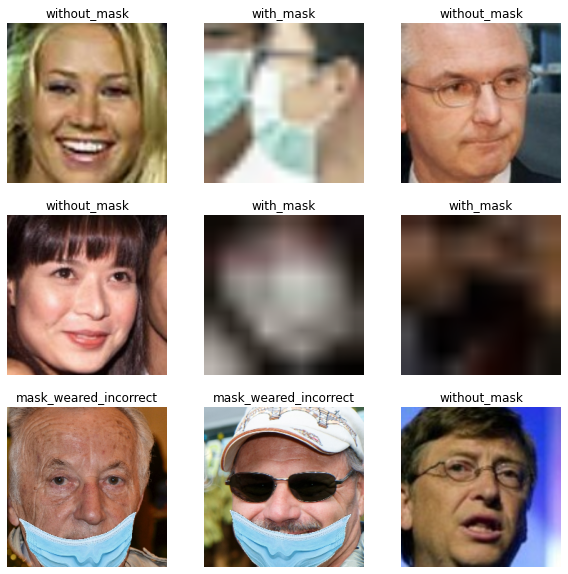

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [ ]:

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(128, 7, 7, 2048)


In [ ]:
base_model.trainable = False


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(128, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation= "softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(128, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
initial_epochs = 2
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/2
61/61 [==============================] - 59s 882ms/step - loss: 1.0507 - accuracy: 0.5629 - val_loss: 0.5708 - val_accuracy: 0.7825
Epoch 2/2
61/61 [==============================] - 54s 860ms/step - loss: 0.3869 - accuracy: 0.8899 - val_loss: 0.2965 - val_accuracy: 0.9286


In [ ]:
import cv2
import numpy as np

img = cv2.imread(r"/content/Screenshot 2022-03-11 201812.png")
img = cv2.resize(img, (224,224))

img = [img]
img = np.array(img)
result = model(img)
print(result)

tf.Tensor([[0.4140185  0.21514861 0.37083292]], shape=(1, 3), dtype=float32)


In [ ]:
base_model.trainable = True


In [ ]:

print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 150


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  190


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/5),
              metrics=['accuracy'])
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 2/3
61/61 [==============================] - 73s 1s/step - loss: 0.0777 - accuracy: 0.9751 - val_loss: 0.0456 - val_accuracy: 0.9836
Epoch 3/3
61/61 [==============================] - 68s 1s/step - loss: 0.0187 - accuracy: 0.9942 - val_loss: 0.0444 - val_accuracy: 0.9876


In [ ]:
import cv2
import numpy as np

img = cv2.imread(r"/content/Screenshot 2022-03-11 193327.png")
img = cv2.resize(img, (224,224))

img = [img]
img = np.array(img)
result = model(img)
result = np.array(result)
result = np.round(result, 3)
print(result)

[[0.015 0.985 0.   ]]


In [ ]:
model.save('/content/gdrive/MyDrive/DAT/airost_demo_facemask_resnetv2_50.h5') 